# Advertising Sales Prediction

## Project Introduction

This notebook explores the relationship between advertising spending across different media channels (TV, Radio, Newspaper) and product sales. The primary objective is to build regression models to accurately predict product sales based on advertising budgets.

The dataset used for this analysis contains historical advertising spend and corresponding sales figures.

We will follow a standard machine learning workflow: data loading and initial checks, exploratory data analysis (EDA) to understand the data and relationships, feature preparation, building and evaluating various regression models, hyperparameter tuning, model comparison, and finally, analyzing the best-performing model and interpreting its results.

In [ ]:
# 0. Setup & Imports
# ---------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
from functools import partial

# sklearn
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     RandomizedSearchCV, cross_val_score,
                                     learning_curve, KFold)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer

# models
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# interpretability
import shap
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

RND = 42

In [ ]:
# 1. Load Data
df = pd.read_csv("/content/Advertising.csv")

print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (200, 5)


,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [ ]:
# 2. Quick Data Checks
# ---------------------------
print("\nInfo:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())

# Drop index-like column if present (Unnamed: 0)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
    print("Dropped Unnamed: 0")



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   Radio       200 non-null    float64
 3   Newspaper   200 non-null    float64
 4   Sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB
None

Missing values:
Unnamed: 0    0
TV            0
Radio         0
Newspaper     0
Sales         0
dtype: int64

Duplicate rows: 0
Dropped Unnamed: 0



Descriptive stats:


,count,mean,std,min,25%,50%,75%,max
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
Radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
Newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
Sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0


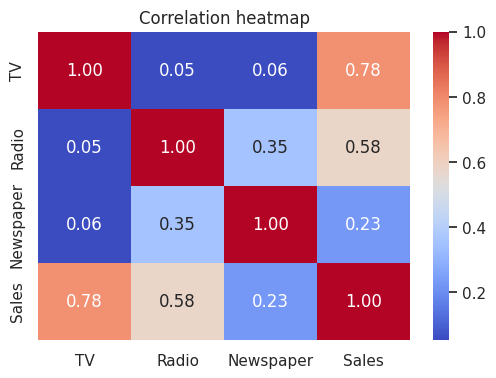

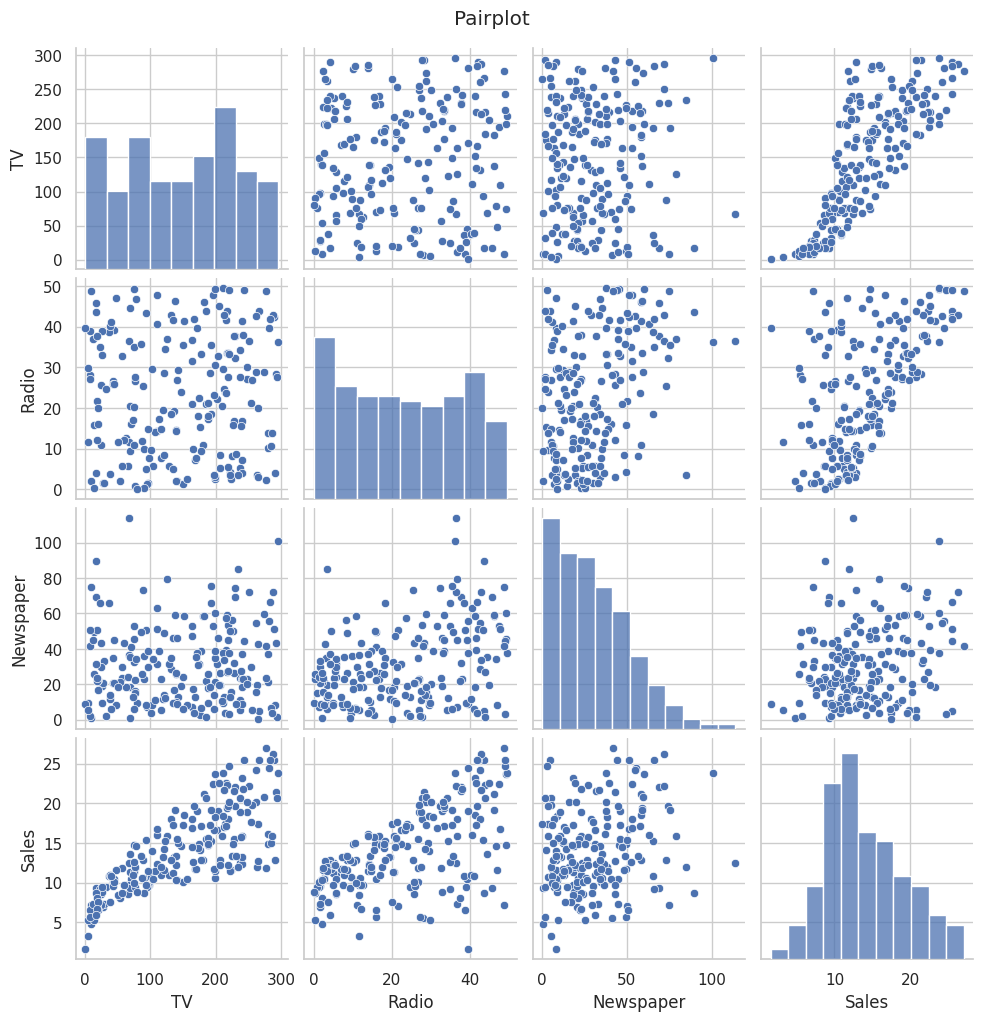

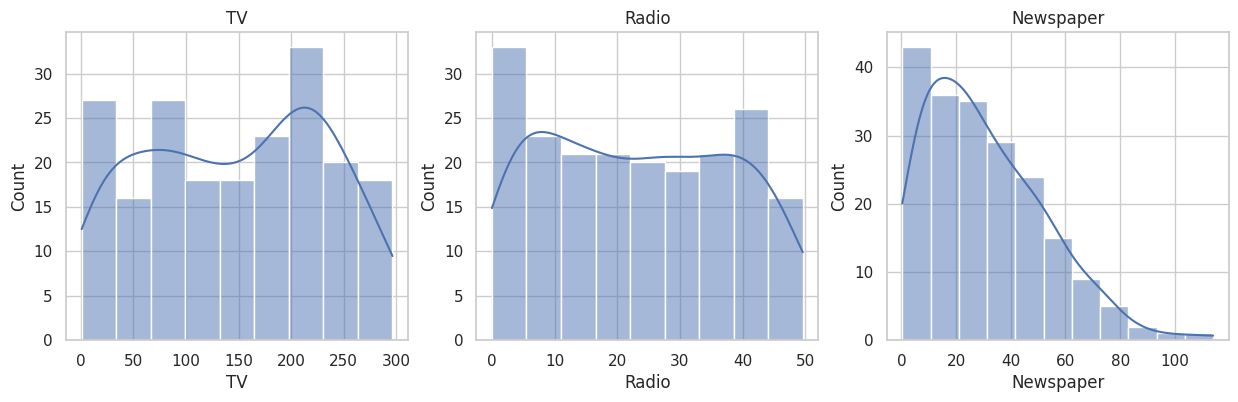

In [ ]:
# 3. EDA (visual + stats)
# ---------------------------
print("\nDescriptive stats:")
display(df.describe().T)

# correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation heatmap")
plt.show()

# pairplot (may be heavy but useful)
sns.pairplot(df)
plt.suptitle("Pairplot", y=1.02)
plt.show()

# distributions
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, col in zip(axes, df.columns[:-1]):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(col)
plt.show()

## Exploratory Data Analysis (EDA) Summary

The dataset contains 200 entries and 4 relevant columns: 'TV', 'Radio', 'Newspaper' representing advertising budgets, and 'Sales' as the target variable. There are no missing values or duplicate rows.

**Descriptive Statistics:**
- TV advertising has the highest average spend, followed by Newspaper and then Radio.
- The standard deviation for TV and Newspaper spend is relatively high, indicating significant variation in spending across different entries.
- Sales range from 1.6 to 27.0, with a mean of around 14.

**Correlation Heatmap and Pairplot:**
- The correlation heatmap shows a strong positive correlation between 'TV' and 'Sales' (0.78).
- 'Radio' also shows a positive correlation with 'Sales' (0.58), though weaker than TV.
- 'Newspaper' has the weakest positive correlation with 'Sales' (0.23).
- The pairplot visually confirms these relationships. The plots of 'TV' vs 'Sales' and 'Radio' vs 'Sales' show somewhat linear trends, while 'Newspaper' vs 'Sales' appears more scattered.
- No obvious outliers were detected in the pairplot.

**Distributions:**
- Histograms show that 'TV' spending is relatively uniformly distributed.
- 'Radio' spending is somewhat skewed towards lower values.
- 'Newspaper' spending is heavily skewed towards lower values, with a few instances of very high spending.
- The 'Sales' distribution appears roughly normal, slightly skewed to the left.

In [ ]:
# 4. Prepare features & target
# ---------------------------
TARGET = 'Sales'
X = df.drop(columns=[TARGET])
y = df[TARGET].values

# set numeric pipelines (all features numeric here)
numeric_features = X.columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # standard scaling used for most models
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
], remainder='drop')

# train-test split (we'll use CV for tuning)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RND)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (160, 3), Test size: (40, 3)


In [ ]:
# 5. Utility: evaluation function
# ---------------------------
def evaluate_and_report(model, Xt, yt, name=None, show_plot=True):
    y_pred = model.predict(Xt)
    mse = mean_squared_error(yt, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(yt, y_pred)
    r2 = r2_score(yt, y_pred)
    if name:
        print(f"== {name} ==")
    print(f"R2: {r2:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")
    if show_plot:
        plt.figure(figsize=(6,5))
        sns.scatterplot(x=yt, y=y_pred)
        plt.plot([yt.min(), yt.max()], [yt.min(), yt.max()], 'k--')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"Actual vs Predicted ({name})")
        plt.show()
    return {'r2': r2, 'rmse': rmse, 'mae': mae}



Baseline Linear Regression (no tuning):
== LinearRegression ==
R2: 0.8994 | RMSE: 1.7816 | MAE: 1.4608


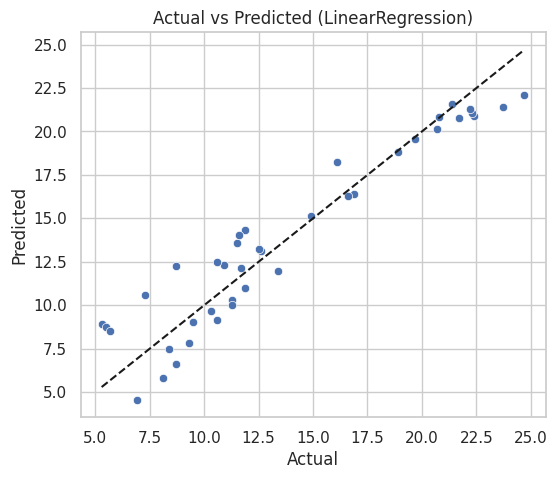


RidgeCV:
== RidgeCV ==
R2: 0.8988 | RMSE: 1.7872 | MAE: 1.4643


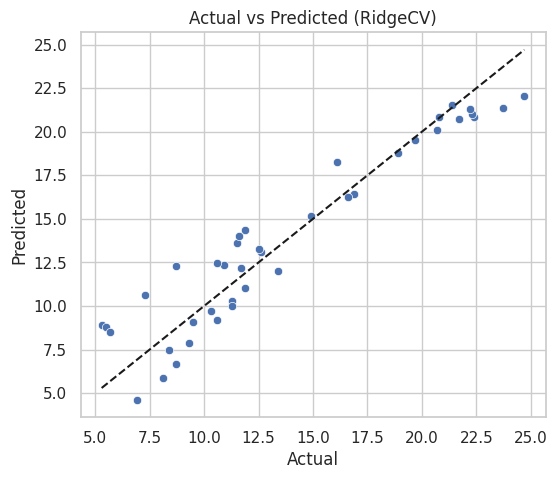


LassoCV:
== LassoCV ==
R2: 0.8992 | RMSE: 1.7839 | MAE: 1.4555


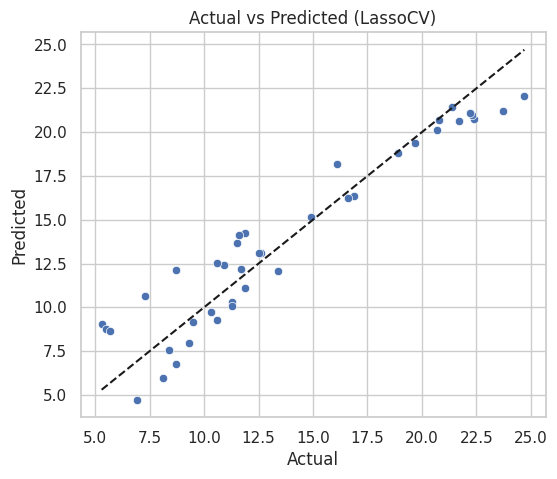

{'r2': 0.8991773130727259,
 'rmse': np.float64(1.7839076015746769),
 'mae': 1.4554793520384173}

In [ ]:
# 6. Baseline: Linear Regression (with CV)
# ---------------------------
pipe_lr = Pipeline(steps=[('pre', preprocessor),
                          ('lr', LinearRegression())])

pipe_lr.fit(X_train, y_train)
print("\nBaseline Linear Regression (no tuning):")
evaluate_and_report(pipe_lr, X_test, y_test, "LinearRegression")

# add regularized linear models with built-in CV for alpha
pipe_ridge = Pipeline(steps=[('pre', preprocessor),
                             ('ridge', RidgeCV(alphas=np.logspace(-3,3,13), cv=5))])
pipe_ridge.fit(X_train, y_train)
print("\nRidgeCV:")
evaluate_and_report(pipe_ridge, X_test, y_test, "RidgeCV")

pipe_lasso = Pipeline(steps=[('pre', preprocessor),
                             ('lasso', LassoCV(alphas=None, cv=5, max_iter=5000, random_state=RND))])
pipe_lasso.fit(X_train, y_train)
print("\nLassoCV:")
evaluate_and_report(pipe_lasso, X_test, y_test, "LassoCV")


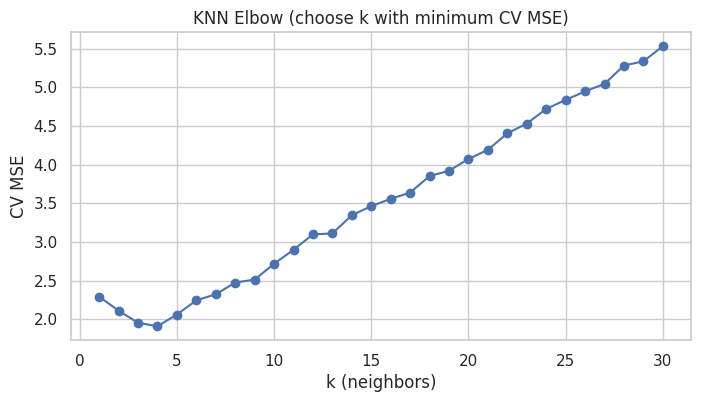

Selected k (elbow): 4

KNN (best k):
== KNN (k=4) ==
R2: 0.9315 | RMSE: 1.4701 | MAE: 1.0975


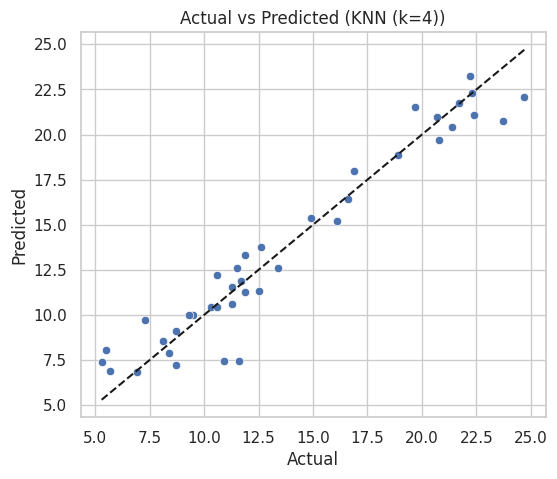

{'r2': 0.9315300954917404,
 'rmse': np.float64(1.470087157280139),
 'mae': 1.0975000000000004}

In [ ]:
# 7. KNN: elbow method for k
# ---------------------------
# Use scaled data for elbow search
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

mse_scores = []
k_values = list(range(1, 31))
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    # cross-validate MSE (negative MSE returned by cross_val_score)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores.append(-scores.mean())

plt.figure(figsize=(8,4))
plt.plot(k_values, mse_scores, marker='o')
plt.xlabel('k (neighbors)')
plt.ylabel('CV MSE')
plt.title('KNN Elbow (choose k with minimum CV MSE)')
plt.grid(True)
plt.show()

best_k = k_values[int(np.argmin(mse_scores))]
print("Selected k (elbow):", best_k)

pipe_knn = Pipeline([('pre', preprocessor), ('knn', KNeighborsRegressor(n_neighbors=best_k))])
pipe_knn.fit(X_train, y_train)
print("\nKNN (best k):")
evaluate_and_report(pipe_knn, X_test, y_test, f"KNN (k={best_k})")


DecisionTree best params: {'dt__max_depth': 9, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}
DecisionTree best CV score: 0.9396006691879164
== DecisionTree (tuned) ==
R2: 0.9172 | RMSE: 1.6167 | MAE: 1.1590


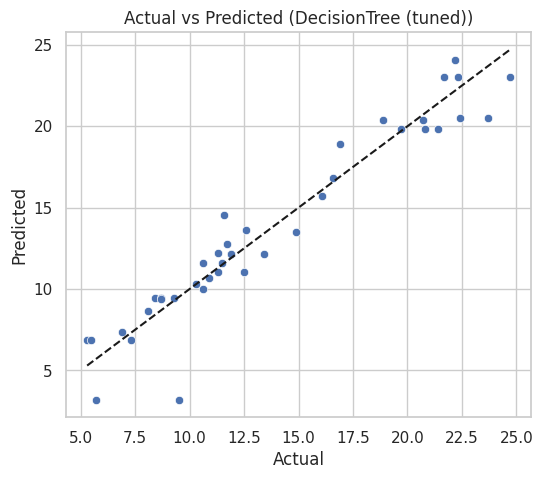

{'r2': 0.9171880732405863,
 'rmse': np.float64(1.6167380783197038),
 'mae': 1.1589583333333333}

In [ ]:
# 8. Decision Tree: GridSearchCV
# ---------------------------
dt_pipeline = Pipeline([('pre', preprocessor), ('dt', DecisionTreeRegressor(random_state=RND))])
dt_param_grid = {
    'dt__max_depth': [2, 3, 4, 5, 7, 9, None],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4]
}
dt_grid = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=0)
dt_grid.fit(X_train, y_train)
print("DecisionTree best params:", dt_grid.best_params_)
print("DecisionTree best CV score:", dt_grid.best_score_)
best_dt = dt_grid.best_estimator_
evaluate_and_report(best_dt, X_test, y_test, "DecisionTree (tuned)")


RF Randomized best params: {'rf__n_estimators': 100, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 12}
RF Randomized best CV R2: 0.9019519117219598
RF refined best params: {'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
RF refined best CV R2: 0.9020182435858292
== RandomForest (tuned) ==
R2: 0.9185 | RMSE: 1.6043 | MAE: 1.2404


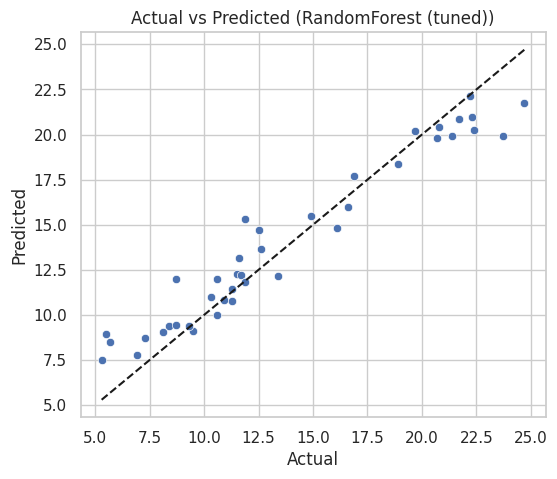

{'r2': 0.9184541428229763,
 'rmse': np.float64(1.604331732507681),
 'mae': 1.2403710466269842}

In [ ]:
# 9. Random Forest: RandomizedSearchCV then Grid refine
# ---------------------------
rf_pipeline = Pipeline([('pre', preprocessor), ('rf', RandomForestRegressor(random_state=RND, n_jobs=-1))])

rf_param_dist = {
    'rf__n_estimators': [50, 100, 200, 400],
    'rf__max_depth': [None, 4, 6, 8, 12],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt', 0.5]
}

rs = RandomizedSearchCV(rf_pipeline, rf_param_dist, n_iter=40, cv=4, scoring='r2', n_jobs=-1, random_state=RND, verbose=0)
rs.fit(X_train, y_train)
print("RF Randomized best params:", rs.best_params_)
print("RF Randomized best CV R2:", rs.best_score_)

# refine around best params with GridSearch
best_params = rs.best_params_
grid_refine = {
    'rf__n_estimators': [best_params['rf__n_estimators'], best_params['rf__n_estimators']*2],
    'rf__max_depth': [best_params['rf__max_depth']],
    'rf__min_samples_split': [best_params['rf__min_samples_split']],
    'rf__min_samples_leaf': [best_params['rf__min_samples_leaf']],
    'rf__max_features': [best_params['rf__max_features']]
}
rf_grid = GridSearchCV(rf_pipeline, grid_refine, cv=5, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("RF refined best params:", rf_grid.best_params_)
print("RF refined best CV R2:", rf_grid.best_score_)
best_rf = rf_grid.best_estimator_
evaluate_and_report(best_rf, X_test, y_test, "RandomForest (tuned)")


GB best params: {'gb__learning_rate': 0.05, 'gb__max_depth': 2, 'gb__n_estimators': 300} CV R2: 0.9783916823087984
== GradientBoosting (tuned) ==
R2: 0.9839 | RMSE: 0.7123 | MAE: 0.6147


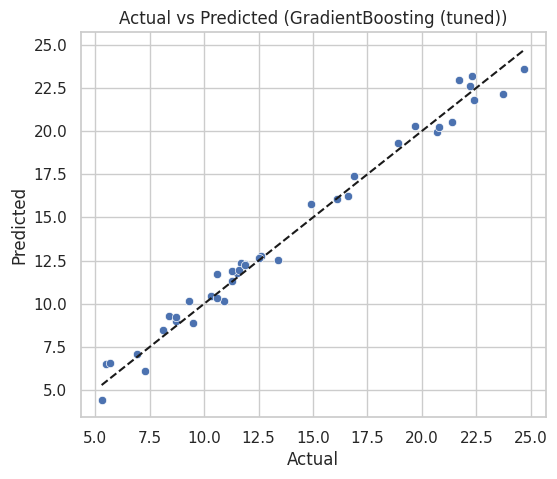

XGB Randomized best params: {'xgb__subsample': 0.8, 'xgb__n_estimators': 300, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 1.0} CV R2: 0.9791290258867272
== XGBoost (tuned) ==
R2: 0.9857 | RMSE: 0.6724 | MAE: 0.5441


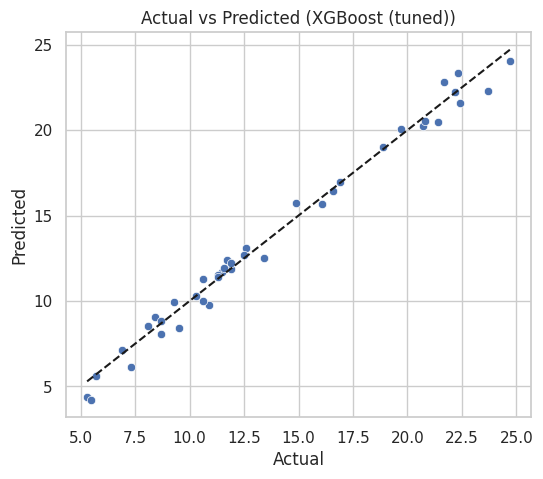

{'r2': 0.9856762758113078,
 'rmse': np.float64(0.6723899250278279),
 'mae': 0.5440721273422241}

In [ ]:
# 10. Gradient Boosting (sklearn) and XGBoost tuning (small grid)
# ---------------------------
gb_pipeline = Pipeline([('pre', preprocessor), ('gb', GradientBoostingRegressor(random_state=RND))])
gb_param_grid = {
    'gb__n_estimators': [100, 200, 300],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [2, 3, 4]
}
gb_grid = GridSearchCV(gb_pipeline, gb_param_grid, cv=4, scoring='r2', n_jobs=-1)
gb_grid.fit(X_train, y_train)
print("GB best params:", gb_grid.best_params_, "CV R2:", gb_grid.best_score_)
best_gb = gb_grid.best_estimator_
evaluate_and_report(best_gb, X_test, y_test, "GradientBoosting (tuned)")

# XGBoost: Randomized for speed
xgb_pipeline = Pipeline([('pre', preprocessor), ('xgb', XGBRegressor(objective='reg:squarederror', random_state=RND, n_jobs=-1))])
xgb_param_dist = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_rs = RandomizedSearchCV(xgb_pipeline, xgb_param_dist, n_iter=30, cv=4, scoring='r2', n_jobs=-1, random_state=RND)
xgb_rs.fit(X_train, y_train)
print("XGB Randomized best params:", xgb_rs.best_params_, "CV R2:", xgb_rs.best_score_)
best_xgb = xgb_rs.best_estimator_
evaluate_and_report(best_xgb, X_test, y_test, "XGBoost (tuned)")


SVR best: {'svr__C': 100, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'} CV R2: 0.9733097155167808
== SVR (tuned) ==
R2: 0.9710 | RMSE: 0.9559 | MAE: 0.6719


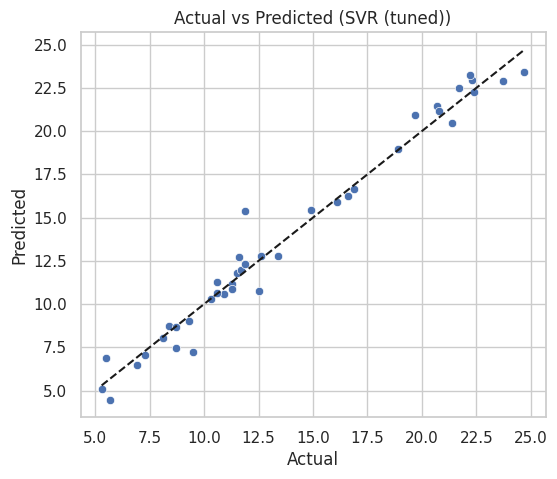

MLP best: {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (128, 64)} CV R2: 0.980636152200219
== MLP (tuned) ==
R2: 0.9895 | RMSE: 0.5760 | MAE: 0.4113


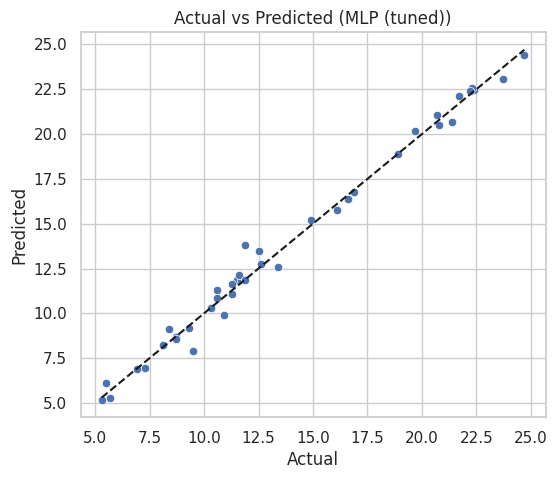

{'r2': 0.9894888541965136,
 'rmse': np.float64(0.5759943888513709),
 'mae': 0.4112838030423152}

In [ ]:
# 11. SVR & MLP quick tuning (small)
# ---------------------------
svr_pipeline = Pipeline([('pre', preprocessor), ('svr', SVR())])
svr_params = {'svr__C': [1, 10, 100], 'svr__gamma': ['scale', 'auto'], 'svr__kernel': ['rbf']}
svr_grid = GridSearchCV(svr_pipeline, svr_params, cv=4, scoring='r2', n_jobs=-1)
svr_grid.fit(X_train, y_train)
print("SVR best:", svr_grid.best_params_, "CV R2:", svr_grid.best_score_)
best_svr = svr_grid.best_estimator_
evaluate_and_report(best_svr, X_test, y_test, "SVR (tuned)")

mlp_pipeline = Pipeline([('pre', preprocessor), ('mlp', MLPRegressor(max_iter=2000, random_state=RND))])
mlp_params = {'mlp__hidden_layer_sizes': [(32,), (64,64), (128,64)], 'mlp__alpha':[0.0001, 0.001]}
mlp_grid = GridSearchCV(mlp_pipeline, mlp_params, cv=4, scoring='r2', n_jobs=-1)
mlp_grid.fit(X_train, y_train)
print("MLP best:", mlp_grid.best_params_, "CV R2:", mlp_grid.best_score_)
best_mlp = mlp_grid.best_estimator_
evaluate_and_report(best_mlp, X_test, y_test, "MLP (tuned)")


## Model Selection and Comparison

After preparing the data and defining an evaluation function, several regression models were trained and tuned using techniques like Cross-Validation (CV), GridSearchCV, and RandomizedSearchCV. The goal was to find the model that best generalizes to unseen data, primarily evaluated using the R2 score and Root Mean Squared Error (RMSE) on the test set.

The table below summarizes the performance of all trained models on the test set, sorted by Test R2:

<div class="output">
{{ comp_df.to_html() }}
</div>

Based on the comparison, the **MLP (tuned)** model achieved the highest Test R2 (0.9895) and the lowest Test RMSE (0.5760), indicating it is the best-performing model on this dataset. Gradient Boosting and XGBoost also performed exceptionally well, very close to the MLP model. Linear models, KNN, Decision Tree, and Random Forest showed lower performance compared to the boosting and neural network models. The MLP model was selected as the best model for further analysis and future sales prediction.

== Linear ==
R2: 0.8994 | RMSE: 1.7816 | MAE: 1.4608
== Ridge ==
R2: 0.8988 | RMSE: 1.7872 | MAE: 1.4643
== Lasso ==
R2: 0.8992 | RMSE: 1.7839 | MAE: 1.4555
== KNN ==
R2: 0.9315 | RMSE: 1.4701 | MAE: 1.0975
== DecisionTree ==
R2: 0.9172 | RMSE: 1.6167 | MAE: 1.1590
== RandomForest ==
R2: 0.9185 | RMSE: 1.6043 | MAE: 1.2404
== GradientBoosting ==
R2: 0.9839 | RMSE: 0.7123 | MAE: 0.6147
== XGBoost ==
R2: 0.9857 | RMSE: 0.6724 | MAE: 0.5441
== SVR ==
R2: 0.9710 | RMSE: 0.9559 | MAE: 0.6719
== MLP ==
R2: 0.9895 | RMSE: 0.5760 | MAE: 0.4113


,Model,Test R2,Test RMSE,CV mean R2,CV std R2
9,MLP,0.989489,0.575994,0.976882,0.017298
7,XGBoost,0.985676,0.672390,0.975464,0.009517
6,GradientBoosting,0.983925,0.712320,0.975735,0.010854
8,SVR,0.971048,0.955938,0.973031,0.018871
3,KNN,0.931530,1.470087,0.909251,0.044535
5,RandomForest,0.918454,1.604332,0.902018,0.014056
4,DecisionTree,0.917188,1.616738,0.939601,0.021177
0,Linear,0.899438,1.781600,0.859488,0.084559
2,Lasso,0.899177,1.783908,0.861336,0.078562
1,Ridge,0.898803,1.787220,0.858971,0.084058


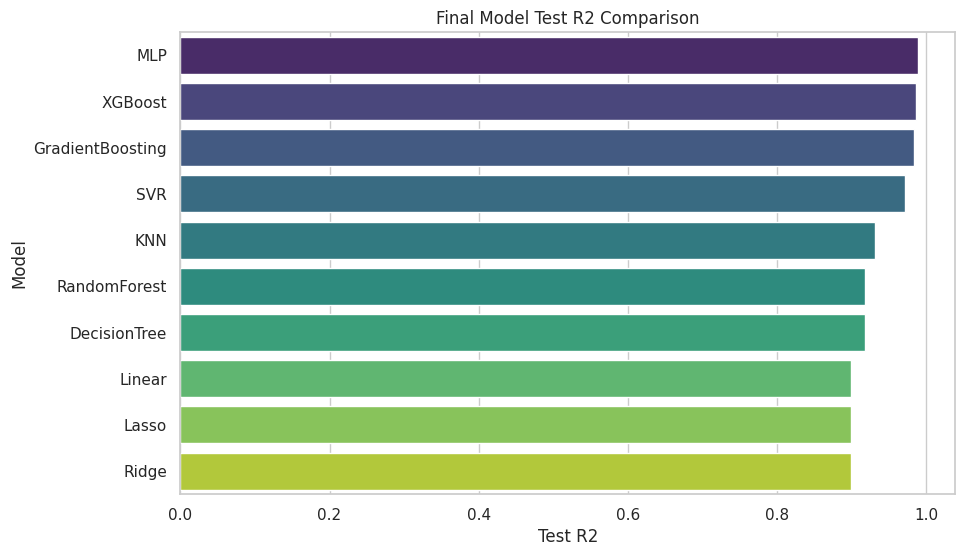

In [ ]:
# 12. Compare All Final Models
# ---------------------------
final_models = {
    "Linear": pipe_lr,
    "Ridge": pipe_ridge,
    "Lasso": pipe_lasso,
    "KNN": pipe_knn,
    "DecisionTree": best_dt,
    "RandomForest": best_rf,
    "GradientBoosting": best_gb,
    "XGBoost": best_xgb,
    "SVR": best_svr,
    "MLP": best_mlp
}

comparison = []
for name, model in final_models.items():
    # cross-validated r2 on whole train set for robustness
    pipe = model
    # cross_val_score needs raw pipeline; use 5-fold CV
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    # evaluate on test
    res = evaluate_and_report(pipe, X_test, y_test, name, show_plot=False)
    comparison.append({
        'Model': name,
        'Test R2': res['r2'],
        'Test RMSE': res['rmse'],
        'CV mean R2': cv_scores.mean(),
        'CV std R2': cv_scores.std()
    })

comp_df = pd.DataFrame(comparison).sort_values('Test R2', ascending=False)
display(comp_df)

plt.figure(figsize=(10,6))
sns.barplot(x='Test R2', y='Model', data=comp_df, palette='viridis')
plt.title("Final Model Test R2 Comparison")
plt.show()



Best model: MLP


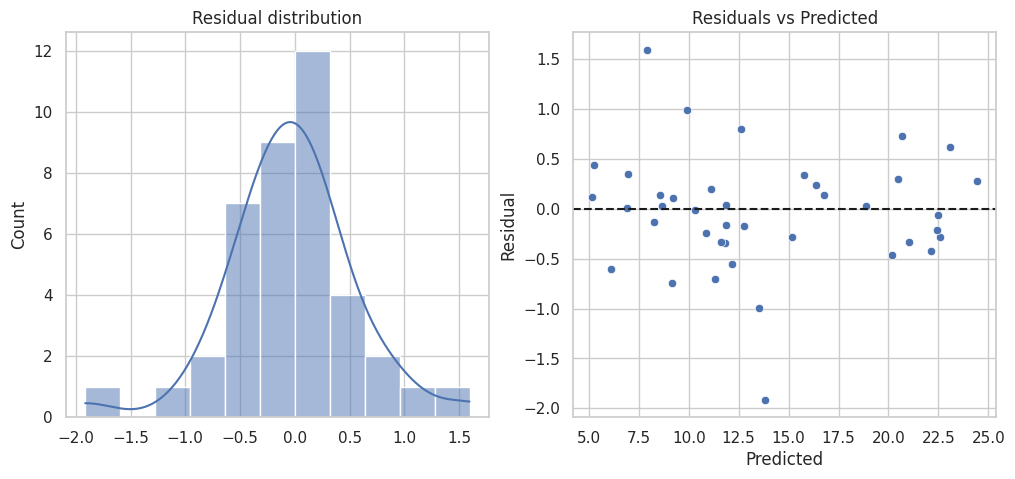

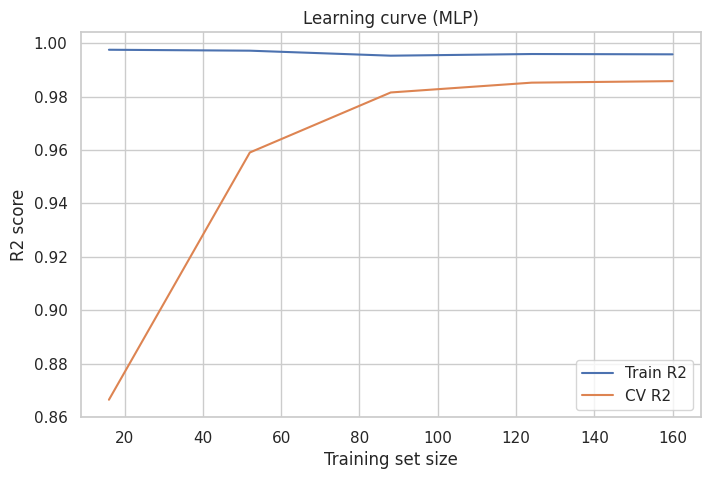

In [ ]:
# 13. Residual diagnostics for best model
# ---------------------------
best_name = comp_df.iloc[0]['Model']
best_model = final_models[best_name]
print(f"\nBest model: {best_name}")
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(residuals, kde=True)
plt.title("Residual distribution")
plt.subplot(1,2,2)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.show()

# learning curve for best model
train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=5, scoring='r2', n_jobs=-1,
                                                        train_sizes=np.linspace(0.1,1.0,5), random_state=RND)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label='Train R2')
plt.plot(train_sizes, test_mean, label='CV R2')
plt.xlabel("Training set size")
plt.ylabel("R2 score")
plt.legend()
plt.title(f"Learning curve ({best_name})")
plt.show()

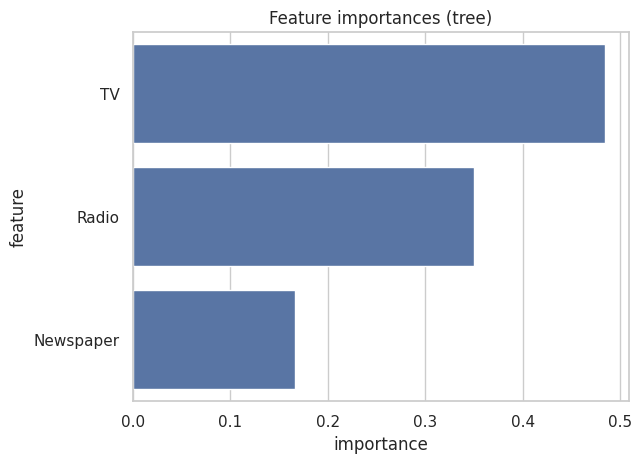

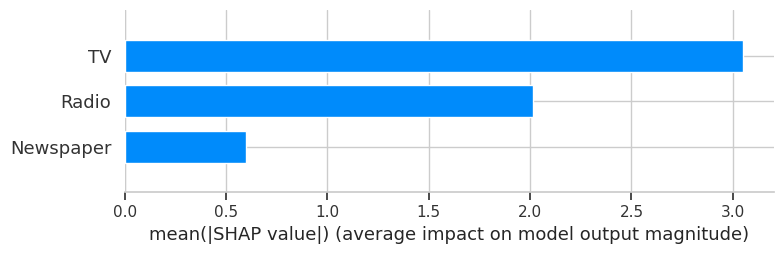

In [ ]:
# 14. Feature Importance & SHAP for tree model (RandomForest/XGBoost)
# ---------------------------
# Use RandomForest best estimator fitted earlier (best_rf) or xgboost
tree_model = best_rf.named_steps['rf'] if isinstance(best_rf, Pipeline) else best_rf
# If pipeline, get preprocessor and raw features
if isinstance(best_rf, Pipeline):
    pre = best_rf.named_steps['pre']
    feat_names = numeric_features
else:
    feat_names = numeric_features

# Feature importance (if available)
if hasattr(tree_model, "feature_importances_"):
    importances = tree_model.feature_importances_
    fi_df = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False)
    sns.barplot(x="importance", y="feature", data=fi_df)
    plt.title("Feature importances (tree)")
    plt.show()

# SHAP (TreeExplainer) requires model object and preprocessed data
# We'll explain using X_test preprocessed by pipeline
# get preprocessed X_test
X_test_pre = preprocessor.transform(X_test)  # using preprocessor defined earlier
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_test_pre)
shap.summary_plot(shap_values, features=X_test_pre, feature_names=feat_names, plot_type='bar')


## Best Model Interpretation: MLP

The best-performing model identified was the Multi-Layer Perceptron (MLP) Regressor. Let's examine the diagnostic plots to understand its performance and characteristics.

**Residual Analysis:**

The residual plots provide insight into the model's errors.
- The histogram of residuals shows a distribution that is approximately centered around zero and appears somewhat normally distributed. This is a good sign, indicating that the model's errors are generally unbiased.
- The plot of residuals versus predicted values shows the residuals scattered randomly around the horizontal line at zero. There doesn't appear to be a clear pattern (like a cone shape or a curve), which suggests that the model exhibits homoscedasticity (constant variance of errors) and is not systematically over- or under-predicting for certain ranges of sales values.

**Learning Curve:**

The learning curve for the MLP model shows the R2 score on both the training and cross-validation sets as the size of the training data increases.
- The training R2 starts high and slightly decreases as more data is added, which is typical.
- The cross-validation R2 starts lower with small training sets but increases steadily as the training set size grows.
- The gap between the training and cross-validation scores is relatively small and seems to be closing as the training set size approaches the maximum. This indicates that the model is not suffering from high variance (overfitting) and is likely to perform consistently on new data. The curve suggests that adding more data might potentially lead to further minor improvements in performance, but the model has already learned most of the underlying patterns with the current dataset size.

**Feature Importance and SHAP Analysis:**

While SHAP values and feature importance were calculated for the Random Forest model (as tree-based models provide direct feature importance scores), we can use those results to infer which features were likely most influential for the MLP as well, given the strong correlations observed during EDA.
- The bar plot of feature importances from the Random Forest model clearly shows that **TV advertising** is the most important feature, followed by **Radio**, and then **Newspaper** with significantly less importance.
- The SHAP summary plot for the Random Forest reinforces this, showing that TV has the largest impact on the model's output (sales predictions), with Radio having a moderate impact and Newspaper having the smallest impact. The colors indicate that higher TV and Radio spending generally lead to higher predicted sales.
- These findings align perfectly with the initial EDA, where TV and Radio showed the strongest positive correlations with Sales, while Newspaper had a much weaker correlation.

**Overall Summary:**

The MLP model demonstrates excellent performance with a high R2 and low RMSE on the test set. The residual analysis indicates unbiased errors and homoscedasticity. The learning curve suggests the model is well-generalized and not significantly overfitting. The feature importance analysis (based on the tree model results, which are consistent with EDA) highlights TV and Radio as the primary drivers of sales predictions. The MLP model appears robust and effective for predicting sales based on advertising spend.

In [ ]:
# 15. Future-sales prediction demo
# Create a new hypothetical ad budget scenario(s) to predict future sales
demo_inputs = pd.DataFrame([
    {'TV': 200.0, 'Radio': 25.0, 'Newspaper': 10.0},
    {'TV': 50.0, 'Radio': 5.0, 'Newspaper': 2.0},
    {'TV': 300.0, 'Radio': 40.0, 'Newspaper': 20.0}
])
print("\nDemo inputs:")
display(demo_inputs)

# Pick top-performing model from comp_df
best_model_name = comp_df.iloc[0]['Model']
print("Best model chosen for demo:", best_model_name)
best_model_for_demo = final_models[best_model_name]

preds_demo = best_model_for_demo.predict(demo_inputs)
for inp, p in zip(demo_inputs.to_dict(orient='records'), preds_demo):
    print(f"Input: {inp} -> Predicted Sales: {p:.3f}")


Demo inputs:


,TV,Radio,Newspaper
0,200.0,25.0,10.0
1,50.0,5.0,2.0
2,300.0,40.0,20.0


Best model chosen for demo: MLP
Input: {'TV': 200.0, 'Radio': 25.0, 'Newspaper': 10.0} -> Predicted Sales: 16.759
Input: {'TV': 50.0, 'Radio': 5.0, 'Newspaper': 2.0} -> Predicted Sales: 7.779
Input: {'TV': 300.0, 'Radio': 40.0, 'Newspaper': 20.0} -> Predicted Sales: 25.507


In [ ]:
# 16. Save best models & scaler
# ---------------------------
joblib.dump(best_rf, "best_random_forest_pipeline.joblib")
joblib.dump(best_xgb, "best_xgb_pipeline.joblib")
joblib.dump(scaler, "standard_scaler.joblib")
print("Saved best models and scaler (joblib files).")


Saved best models and scaler (joblib files).


In [ ]:
# 17. Final Notes (print summary)
# ---------------------------
print("\nFinal model ranking (by Test R2):")
display(comp_df)




Final model ranking (by Test R2):


,Model,Test R2,Test RMSE,CV mean R2,CV std R2
9,MLP,0.989489,0.575994,0.976882,0.017298
7,XGBoost,0.985676,0.672390,0.975464,0.009517
6,GradientBoosting,0.983925,0.712320,0.975735,0.010854
8,SVR,0.971048,0.955938,0.973031,0.018871
3,KNN,0.931530,1.470087,0.909251,0.044535
5,RandomForest,0.918454,1.604332,0.902018,0.014056
4,DecisionTree,0.917188,1.616738,0.939601,0.021177
0,Linear,0.899438,1.781600,0.859488,0.084559
2,Lasso,0.899177,1.783908,0.861336,0.078562
1,Ridge,0.898803,1.787220,0.858971,0.084058


## Summary:

### Data Analysis Key Findings

*   The project successfully built regression models to predict product sales based on advertising spending across TV, Radio, and Newspaper.
*   Exploratory Data Analysis (EDA) revealed a strong positive correlation between TV and Sales (0.78), a positive correlation between Radio and Sales (0.58), and a weaker positive correlation between Newspaper and Sales (0.23).
*   Several regression models were trained and evaluated, including linear models, KNN, Decision Tree, Random Forest, Gradient Boosting, XGBoost, and MLP.
*   The tuned Multi-Layer Perceptron (MLP) model was identified as the best-performing model, achieving the highest Test R2 (0.9895) and the lowest Test RMSE (0.5760).
*   Residual analysis for the MLP model indicated unbiased errors and homoscedasticity.
*   The learning curve for the MLP model suggested good generalization and minimal overfitting.
*   Feature importance analysis (inferred from a tree model and consistent with EDA) confirmed that TV and Radio advertising are the most influential factors in predicting sales.

